DBSCAN
===============
_Density-based spatial clustering of applications with noise_
***

TODO: Explanantion of DBSCAN

Clustering Of _Waking-up_ and _Sleep_ timings
=================
*****************
The following algorithm below will cluster sleep periods using the [DBSCAN algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) from the [scikit-learn library](http://scikit-learn.org/)

Input data requirements
---------------------
****
The data input is expected to follow the following format:

<table>
<th>TODO</th>
</table>

In [11]:
%matplotlib inline
###########################################IMPRORTS#########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi
from sklearn.cluster import DBSCAN
import eps_min_pts as eps_And_MinPts
from matplotlib.backends.backend_pdf import PdfPages
###########################################IMPRORTS#########################################


# To return value in mins / total mins in one day
def to_mins(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return (x.value - pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day)).value) / (60 * (10**9))

# Helper method to convert values to radian
def convert_to_radian(x):
    return ((x / (24*60)) * 2 * pi)

# Returns a distance matrix (a numpy array)
def get_x_from_df(series):
    
    # Vectorizing to_mins and to_radian functions
    tmin = np.vectorize(to_mins)
    trad = np.vectorize(convert_to_radian)

    # Converting series of timestamp -> minutes / total minuites in a day -> radian
    input_rad = trad(tmin(series))

    # Convert time to rad points   
    X = input_rad[None,:] - input_rad[:,None]

    # Assign 'shortest distance to each point
    X[((X > pi) & (X <= (2*pi)))] = X[((X > pi) & (X <= (2*pi)))] -(2*pi)
    X[((X > (-2*pi)) & (X <= (-1*pi)))] = X[((X > (-2*pi)) & (X <= (-1*pi)))] + (2*pi) 
    X = abs(X)

    return X,input_rad

# Returns output from sklearn DBSCAN method
def dbscan(eps, min_pts, X, metric='precomputed'):
    db = DBSCAN(eps, min_pts, metric)
    db.fit(X)
    return db.labels_, db.components_, db.core_sample_indices_

def configure_polar_plot(axes):
    xticklabels = [str(x) for x in range (0,24)]
    axes.set_xticks(np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi))
    axes.set_xticklabels(xticklabels)
    axes.set_theta_zero_location('N')
    axes.set_theta_direction(-1)
    axes.set_ylim([0,1])
    axes.set_yticks([0.8,0.6])
    axes.set_yticklabels(['Sleep-Start', 'Sleep-End'])
    
    return axes

def plot_clusters(labels, rad_tseries, axes, ring):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k,col in zip(unique_labels, colors):
        marker = '.'
        ms = 30.0
        if k == -1:
            col='k'
            marker = 'x'
            ms = 8.0

        indices_of_k, = np.where(labels == k)
        data = rad_tseries.take(indices_of_k)
        axes.plot(data, [ring for x in data], color=col, marker=marker, linestyle='none', ms=ms, mec='k')
        

File name:  sleep/sleep-aggregate_2016-01_S033.csv
[ 0.          2.38375615  2.46382313 ...,  2.7611836   2.06472451  0.        ]
eps:  0.313890193766  minPts:  12.5
[ 0.          2.29845318  2.41240864 ...,  2.51509217  0.38382699  0.        ]
eps:  0.314064726691  minPts:  13.0
Number of clusters for start sleep time:  4
Number of clusters for end sleep time:  3


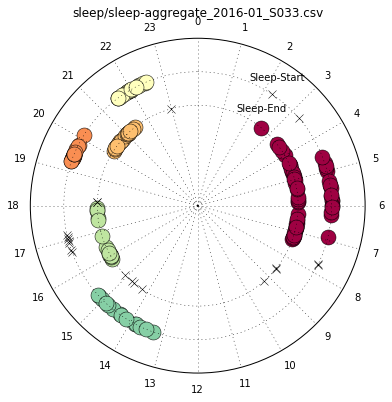

Elasped Time:  0.281 seconds


In [14]:
# Code
# Start timer:
time_now = time.time()

### Globals ###
file_dir = 'sleep'
# Perform clustering on files 1 to 10
# indexes = [str(x) for x in range(1,10)]
index = '9'

file_name = ''.join([file_dir,'/','sleep-aggregate_2016-01_S033.csv'])
# print file name
print('File name: ', file_name)

# Get dataframe containing readings from sensor reading, exclude 
df = pd.read_csv(file_name, delimiter=',', usecols=[x for x in range(1,7)],parse_dates=[1])
column_names = list(df.columns.values)
# print(column_names)

# X is a distance matrix.
# Set 'X1' as sleep_start timings
X1,X1_rad_series = get_x_from_df(df['sleep_start'])

# Set 'X2' as sleep_end timings
X2,X2_rad_series = get_x_from_df(df['sleep_end'])

# TODO
# 1. Implement method to calculate EPS
# 2. Get output for both X1 and X2
# 3. Construct cluster plot. Polar plot

# Arbitrary eps and min_pts value:
eps_X1, min_pts_X1 = eps_And_MinPts.knee_calculate_eps_minPts(X1)
print('eps: ', eps_X1 , ' minPts: ' , min_pts_X1)
eps_X2, min_pts_X2 = eps_And_MinPts.knee_calculate_eps_minPts(X2)
print('eps: ', eps_X2 , ' minPts: ' , min_pts_X2)
# eps = 0.31
# min_pts = 29

X1_label, X1_components, X1_csi = dbscan(eps_X1, min_pts_X1, X1)
X2_label, X2_components, X2_csi = dbscan(eps_X2, min_pts_X2, X2)

# Sanity check here:
# print('Sanity check.......')
# print('Checking.........................')
# print('start sleep time cluster: ')

# - 1 if -1 exist in labels because -1 is used to denote noise
X1_no_clusters = len(set(X1_label)) - (1 if -1 in X1_label else 0)
print('Number of clusters for start sleep time: ', X1_no_clusters )
# print('end sleep time cluster: ')
X2_no_clusters = len(set(X2_label)) - (1 if -1 in X2_label else 0)
print('Number of clusters for end sleep time: ', X2_no_clusters )

# EXTRACTION OF CLUSTERS
###########################################


##################PLOTTING####################
# TODO: CLUSTER
fig = plt.figure(figsize=(6,6))
ax1 = configure_polar_plot(fig.add_subplot(111, projection='polar'))
ax1.set_title(file_name)
# ax1.plot(X1_rad_series, [1 for x in X1_rad_series], 'mo')
# ax1.plot(X2_rad_series, [0.8 for x in X2_rad_series], 'y*')
plot_clusters(X1_label, X1_rad_series, ax1, 0.8)
plot_clusters(X2_label, X2_rad_series, ax1, 0.6)
plt.show()

print("Elasped Time: ", round(time.time() - time_now, 3), "seconds")
    